<center><span style="font-size:35px"><b>CNN on Reduced MNIST</b></span></center>
<center><span style="font-size:20px"><b>- PELLÉ Servan -</b></span></center>

# 1# - Subject 

> MNIST (Modified National Institute of Standards and Technology) is a widely-used dataset in the field of machine learning and computer vision. It consists of a collection of handwritten digits, ranging from 0 to 9, each digit being represented as a grayscale image with a size of 28x28 pixels. MNIST serves as a benchmark for evaluating algorithms and models, particularly in tasks related to image classification and digit recognition. Its simplicity and standardization have made it a cornerstone dataset for researchers and practitioners alike, providing a common ground for comparing the performance of different approaches in the domain of pattern recognition and machine learning.

<p align="center">
  <img src="./snip/mnist.jpeg" alt="MNIST" width="500"/>
</p>

# 2# - Objective

### Use only __100__ labelized images to train a CNN.

> Limiting training a Convolutional Neural Network (CNN) to just 100 labeled images presents several challenges. First and foremost, the size of the dataset severely restricts the model's ability to learn complex patterns and generalize well to unseen data. With only 100 labeled examples, the model may struggle to capture the diversity and variability present in the data distribution, leading to overfitting or poor performance on unseen samples.
>
> Additionally, the limited dataset size exacerbates the risk of sampling bias, where the training set may not adequately represent the full spectrum of variations present in the real-world data. This can result in a CNN that performs well on the training set but fails to generalize to new instances.
>
> Furthermore, training a CNN with such a small dataset requires careful consideration of regularization techniques to mitigate overfitting. Regularization methods such as dropout, weight decay, and data augmentation become crucial in preventing the model from memorizing the training examples and instead encourage it to learn meaningful features.
>
> In summary, constraining training to just 100 labeled images for a CNN poses significant challenges in terms of model generalization, risk of overfitting, and potential sampling bias. Addressing these challenges requires thoughtful application of regularization techniques and careful consideration of dataset representativeness.

# 3# - Imports

#### We'll use PyTorch and its comprehensive set of functions for this project for several reasons:
> __Flexibility:__ PyTorch provides a flexible framework that allows for dynamic computation graphs, making it suitable for designing and training complex neural network architectures.
>
> __Ease of Use:__ PyTorch offers an intuitive and Pythonic interface, which simplifies the process of building, training, and deploying deep learning models.
>
> __Efficient GPU Support:__ PyTorch seamlessly integrates with GPUs, leveraging their computational power to accelerate training and inference processes significantly.
>
> __Rich Library:__ PyTorch comes with a rich collection of built-in functions and modules for various deep learning tasks, including image processing, optimization, and evaluation.
>
> __Community Support:__ PyTorch has a vibrant community of developers and researchers, providing access to a wealth of resources, tutorials, and pre-trained models that can expedite the development process.
>
> In essence, by leveraging PyTorch and its extensive functionalities, we can efficiently implement and train Convolutional Neural Networks for our project, benefiting from its flexibility, ease of use, GPU support, rich library, and strong community support.

#### Utiles.py:
> We've developed a file named utils.py that includes various functions crucial for our project. These functions are designed to streamline common tasks such as data preprocessing, model evaluation, and performance metrics computation. By centralizing these utility functions in one file, we can maintain code organization, improve readability, and facilitate reusability throughout the project. This approach enhances efficiency and reduces redundancy, enabling smoother development and experimentation with our Convolutional Neural Network.

In [1]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F

from utiles import eval_model, classwise_accuracy, confusion_matrix_plot

ROOT = './data'

## 4# - Get 10 samples for each number from MNIST train dataset

> By choosing to take 10 images of each digit to create a dataset of 100 samples, I ensure a balanced representation of each class in my dataset. This means that my machine learning model will be trained fairly across the different digits. Without this balancing, my model might be biased towards classes that are over-represented, leading to poor performance on under-represented classes when evaluated on new data. By ensuring an equal sampling of each class, I improve the generalization ability of my model and its capacity to correctly recognize all digits.

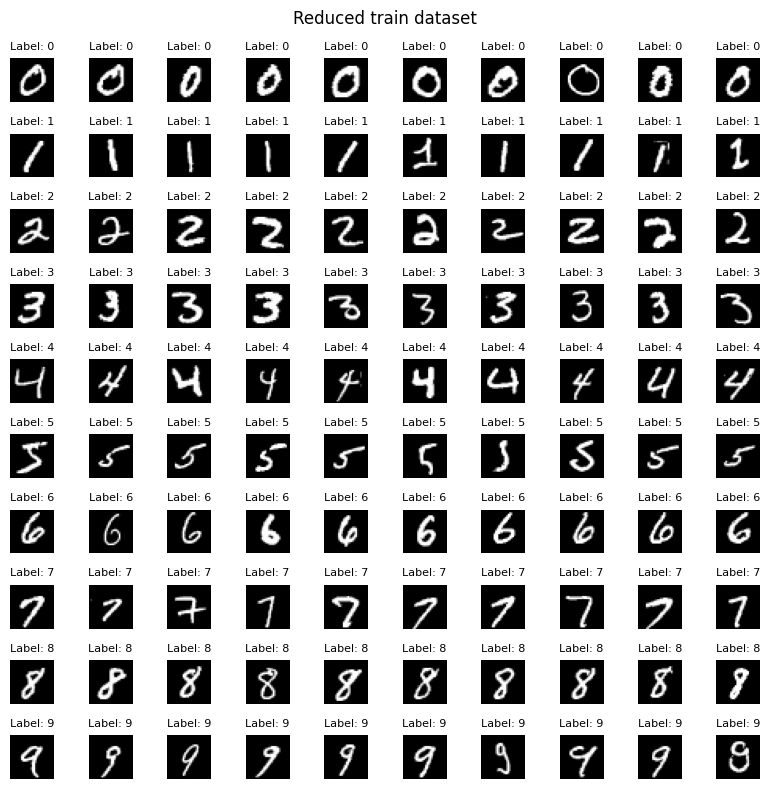

In [2]:
# Get full MNIST train dataset
trainset = MNIST(root=ROOT, train=True, download=True, transform=None)

# Get 10 samples for each number
samples_per_digit = {digit: [] for digit in range(10)}
count_per_digit = {digit: 0 for digit in range(10)} 
for image, label in trainset:
    digit = label  
    if count_per_digit[digit] < 10:
        samples_per_digit[digit].append((image, label))
        count_per_digit[digit] += 1
    if all(count == 10 for count in count_per_digit.values()):
        break
    
labeled_train_subset = [sample for samples in samples_per_digit.values() for sample in samples]

# Display train reduced dataset
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = labeled_train_subset[i]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {label}", fontsize=8)
    ax.axis('off')

fig.suptitle('Reduced train dataset', fontsize=12)

plt.tight_layout()
plt.show()

# 5# - Define CNN network model
We will use a network allready used in this article : [https://www.kaggle.com/code/stephanedc/tutorial-cnn-partie-1-mnist-digits-classification](https://www.kaggle.com/code/stephanedc/tutorial-cnn-partie-1-mnist-digits-classification)

> This network is a Convolutional Neural Network (CNN) architecture designed for image classification tasks. Here's a quick breakdown of its components:
> 
> __Convolutional Layers:__ The conv1, conv2, conv3, and conv4 layers are convolutional layers that extract features from images by applying convolutional filters.
> 
> __Batch Normalization Layers:__ The bn1, bn2, bn3, and bn4 layers perform batch normalization, which speeds up network convergence by stabilizing the distribution of activations.
>
> __Pooling Layers:__ The pool1 and pool2 layers are pooling layers that reduce the spatial dimensionality of activations by taking the maximum values within a given window.
> 
> __Dropout Layers:__ The dropout1, dropout2, dropout3, and dropout4 layers are regularization layers that randomly deactivate some neurons during training to prevent overfitting.
>
> __Fully Connected Layers (Linear Layers):__ The fc1, fc2, and fc3 layers are fully connected layers that take flattened activations from the last pooling layer and produce a final output.
>
> __ReLU Activation:__ The Rectified Linear Unit (ReLU) activation function is used after each convolutional and fully connected layer, except for the last layer where it's replaced with a direct output.
>
> __Flatten Layer:__ The flatten layer transforms the activations from the last pooling layer into a one-dimensional vector before passing them to the fully connected layers.
>
> The forward propagation process traverses these layers in the specified order, applying convolution, normalization, pooling, regularization, and activation operations until the final output is produced, ready for classification.

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1600, 1024)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout4 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)

        return x

# 6# - Transform Train Dataset Images into Tensor and Define a Loader

In [4]:
# Transformage into tensor
transform = transforms.Compose([transforms.ToTensor()])

labeled_train_subset_tensored = []
for img, label in labeled_train_subset:
    current_sample = []
    current_sample.append(transform(img))
    current_sample.append(label)
    labeled_train_subset_tensored.append(current_sample)

# Define trainloader
trainloader = DataLoader(labeled_train_subset_tensored, batch_size=64, shuffle=True)

# 7# - Define optimizer

> So, in our project, we have the opportunity to choose from various optimization algorithms, each with its own unique characteristics. It's crucial to select the right optimizer because it directly influences how our neural network learns and updates its parameters during training.
>
> Different optimizers have different behaviors and performance on various types of datasets and tasks. For instance, some optimizers might converge faster on certain types of data, while others might struggle or even diverge. Additionally, some optimizers might be more robust to noisy or ill-conditioned data, while others might require careful tuning of hyperparameters to perform well.
>
> Choosing the right optimizer involves considering factors such as the nature of our data, the architecture of our neural network, and the specific requirements of our task. By carefully selecting the optimizer, we can potentially improve the convergence speed, stability, and overall performance of our model.
>
> Ultimately, the choice of optimizer can have a significant impact on the effectiveness and efficiency of our machine learning model. Therefore, it's essential to experiment with different optimizers and evaluate their performance to determine which one best suits our problem. This iterative process of optimization selection and evaluation is key to achieving the best results for our project.

#### Selected optimizers:
> __Adam:__ Adam stands for Adaptive Moment Estimation. It combines the advantages of two other popular optimization algorithms - AdaGrad and RMSProp. Adam maintains adaptive learning rates for each parameter and calculates individual adaptive learning rates for different parameters. It's known for its robustness and efficiency in optimizing deep learning models.
>
> __Adadelta:__ Adadelta is an extension of the Adagrad optimization algorithm that seeks to address Adagrad's aggressive and monotonically decreasing learning rate. Adadelta dynamically adapts the learning rate over time based on a moving window of the gradient's squared values, allowing it to converge more quickly and often requiring fewer hyperparameters to tune.
>
> __SGD (Stochastic Gradient Descent):__ SGD is the most basic optimization algorithm used in neural networks. It updates the model's parameters in the direction of the negative gradient of the loss function with respect to the parameters. While it's simple and easy to implement, it can sometimes be slow to converge and may get stuck in local minima.
>
> __RMSprop:__ RMSprop, short for Root Mean Square Propagation, is an adaptive learning rate optimization algorithm that maintains a moving average of the square of gradients for each weight, adjusting the learning rates of each weight based on their importance. It helps mitigate the vanishing and exploding gradient problems often encountered in deep learning.
>
> __Adagrad:__ Adagrad stands for Adaptive Gradient Algorithm. It adapts the learning rate of each parameter by scaling it inversely proportional to the square root of the sum of historical squared gradients. It's effective in training sparse data but can have issues with rapidly diminishing learning rates.

In [5]:
# model = CNN()


# # Define learning rate and criteration
# lr = 0.0001
# criterion = nn.CrossEntropyLoss()

# # Create optimizer instences
# optimizers = {
#     'Adam': optim.Adam(model.parameters(), lr=lr),
#     'Adadelta': optim.Adadelta(model.parameters()),
#     'SGD': optim.SGD(model.parameters(), lr=lr),
#     'RMSdrop': optim.RMSprop(model.parameters(), lr=lr),
#     'ADAgrad': torch.optim.Adagrad(model.parameters(), lr=lr)
# }

# num_epochs = 200
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# loss_dict = {optimizer_name: [] for optimizer_name in optimizers}

# # Train model with the diferents defined optimizers
# for optimizer_name, optimizer in optimizers.items():
#     model = CNN()  
#     model.to(device)  
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     print(f"Start training with {optimizer_name}")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in tqdm(trainloader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         loss_dict[optimizer_name].append(running_loss)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")
#     print(f"{optimizer_name} done\n")

# print("Training done.")


## 7.1# - Display traning loss evolution

In [6]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for optimizer_name, loss in loss_dict.items():
#     iteration = np.arange(len(loss))
#     axes[0].plot(iteration, loss, label=f'{optimizer_name}')
#     axes[1].plot(iteration[:20], loss[:20], label=f'{optimizer_name}')

# axes[0].set_title('All epochs')
# axes[0].set_xlabel(r'$Epochs$')
# axes[0].set_ylabel(r'$Training\;Cost$')
# axes[0].grid(linestyle = '--', linewidth = 0.5)
# axes[0].legend(title='Optimizer:', loc='upper right')

# axes[1].set_title('Zoom in')
# axes[1].set_xlabel(r'$Epochs$')
# axes[1].set_ylabel(r'$Training\;Cost$')

# axes[1].grid(linestyle = '--', linewidth = 0.5)
# axes[1].legend(title='Optimizer:', loc='upper right')

# fig.suptitle('Loss Evolution', fontsize=12)

# plt.tight_layout()
# plt.show()

![./snip/loss_evolution_optimizers.png](./snip/loss_evolution_optimizers.png)

## 7.2 - Conclusion

Upon analyzing the chart above, it becomes apparent that determining the most appropriate optimizer for our problem is challenging. This difficulty primarily stems from the size of the training dataset. Our dataset is relatively small, which hampers a comprehensive study on the effectiveness of different optimizers.

However, there is still valuable insight we can glean from existing research to guide our choice of optimizer. Referring to the article [An Empirical Comparison of Optimizers for Machine Learning Models](https://heartbeat.comet.ml/an-empirical-comparison-of-optimizers-for-machine-learning-models-b86f29957050), we find:

#### Utilized Datasets
The research employs various datasets, including:

> - MNIST 
>
> - CIFAR10
>
> - IMDB Reviews


#### Optimizers Tested
For each dataset, the models are trained using several optimizers, namely:

> - SGD $\left(lr=0.01\right)$
>
> - RNSProp $\left(lr=0.001\right)$
> 
> - AdaGrad $\left(lr=0.001\right)$
>
> - Adam $\left(lr=0.001\right)$

#### Monitored Metrics
Throughout the training process, the following metrics are monitored:

> - Training Accuracy
>
> - Validation Accuracy
>
> - Training Loss
>
> - Validation Loss

#### MNIST Resuts
<div style="display: flex;">
  <table>
    <tr>
      <th>Optimizer</th>
      <th>Training Accuracy</th>
      <th>Training Loss</th>
      <th>Validation Accuracy</th>
      <th>Validation Loss</th>
    </tr>
    <tr>
      <td>SGD</td>
      <td>89,54%</td>
      <td>0,3798</td>
      <td>90,27%</td>
      <td>0.3657</td>
    </tr>
    <tr>
      <td>AdaGrad</td>
      <td>91,06%</td>
      <td>0,3228</td>
      <td>91,45%</td>
      <td>0.3167</td>
    </tr>
    <tr>
      <td>RMSProp</td>
      <td>99,37%</td>
      <td>0.0248</td>
      <td>97,67%</td>
      <td>0.0813</td>
    </tr>
    <tr>
      <td>Adam</td>
      <td>99,56%</td>
      <td>0.0210</td>
      <td>97,60%</td>
      <td>0.0790</td>
    </tr>
  </table>
  <img src="./snip/mnist_results.png" alt="Image" style="width: 70%; margin-left: 5px">
</div>

#### Conclusion
Based on the results above, the Adam optimizer demonstrates superior performance under these conditions. Therefore, we'll employ it to train our model.

# 8# - Define Criterion

> Choosing a good loss criterion is crucial because it determines how effectively our model learns from the data. A well-defined criterion ensures that the model optimizes towards the desired outcome, guiding it to minimize errors and make accurate predictions. It acts as a feedback mechanism, providing the necessary signal to adjust the model's parameters during training. Ultimately, the choice of criterion directly impacts the model's performance, convergence speed, and generalization ability, making it essential for achieving optimal results in machine learning tasks.

#### Selected Criterion

> __CrossEntropyLoss__: CrossEntropyLoss is a widely used loss function in classification tasks. It measures the discrepancy between the predicted probability distribution by the model and the true distribution of the labels. This loss penalizes incorrect classifications more severely, encouraging the model to make confident and accurate predictions.
>
> __NLLLoss (Negative Log Likelihood Loss):__ NLLLoss is commonly used when the output of the model is log-probabilities. It calculates the negative log likelihood of the predicted probability distribution for each class, given the true class. This loss function is suitable for multi-class classification tasks and encourages the model to assign higher probabilities to the correct classes while minimizing the overall negative log likelihood.


In [7]:
# model = CNN()   
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# lr = 0.001
# # Define several criterions
# criterions = {
#                 'CrossEntropy': nn.CrossEntropyLoss(),
#                 'NLL': nn.NLLLoss()
#             }
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# num_epochs = 200

# criterion_dict = {criterion: [] for criterion in criterions}

# # Train model with the diferents defined optimizers
# for criterion_name, _ in criterion_dict.items():
#     model = CNN()  
#     model.to(device)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     current_criterion = criterions[criterion_name]
#     print(f"Start training with: {lr}")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in tqdm(trainloader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = current_criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         criterion_dict[criterion_name].append(running_loss)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")
#     print(f"Training with learning rate: {lr} done\n")

# print("Training done.")


## 8.1 - Display Training Loss Evolution

In [8]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for criterion_name, loss in criterion_dict.items():
#     iteration = np.arange(len(loss))
#     axes[0].plot(iteration, loss, label=f'{criterion_name}')
#     axes[1].plot(iteration[:20], loss[:20], label=f'{criterion_name}')

# axes[0].set_title('All epochs')
# axes[0].set_xlabel(r'$Epochs$')
# axes[0].set_ylabel(r'$Training\;Cost$')
# axes[0].grid(linestyle = '--', linewidth = 0.5)
# axes[0].legend(title='Learning rate:', loc='upper right')

# axes[1].set_title('Zoom in')
# axes[1].set_xlabel(r'$Epochs$')
# axes[1].set_ylabel(r'$Training\;Cost$')
# axes[1].grid(linestyle = '--', linewidth = 0.5)
# axes[1].legend(title='Learning rate:', loc='upper right')

# fig.suptitle('Loss Evolution', fontsize=12)

# plt.tight_layout()
# plt.show()

![](./snip/loss_evolution_criterions.png)

## 8.2 - Conclusion

> These results are not usable

# 9# - Define Learning Rate

> Choosing the right learning rate is crucial because it determines the step size during the optimization process. A good learning rate allows the model to converge efficiently to the optimal solution without overshooting or getting stuck in local minima. Too high a learning rate may lead to unstable training, causing the loss to oscillate or diverge, while too low a learning rate may result in slow convergence or getting trapped in shallow minima. Finding the optimal learning rate ensures faster convergence, better generalization, and improved performance of the model on unseen data.

In [9]:
# model = CNN()  
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)  

# # Define learning rate and criteration
# learning_rates = 1 / np.power(10, np.arange(6))
# criterion = nn.CrossEntropyLoss()
# num_epochs = 200

# learning_rate_dict = {learning_rate: [] for learning_rate in learning_rates}

# # Train model with several learning rates
# for learning_rate, _ in learning_rate_dict.items():
#     model = CNN()  
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     print(f"Start training with learning rate: {learning_rate}")
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in tqdm(trainloader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         learning_rate_dict[learning_rate].append(running_loss)
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")
#     print(f"Training with learning rate: {learning_rate} done\n")

# print("Training done.")

## 9.1# - Display Training Loss Evolution

In [10]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for learning_rate_name, loss in learning_rate_dict.items():
#     iteration = np.arange(len(loss))
#     axes[0].plot(iteration, loss, label=f'{learning_rate_name}')
#     axes[1].plot(iteration[:20], loss[:20], label=f'{learning_rate_name}')

# axes[0].set_title('All epochs')
# axes[0].set_xlabel(r'$Epochs$')
# axes[0].set_ylabel(r'$Training\;Cost$')
# axes[0].set_yscale('log')
# axes[0].grid(linestyle = '--', linewidth = 0.5)
# axes[0].legend(title='Learning rate:', loc='upper right')

# axes[1].set_title('Zoom in')
# axes[1].set_xlabel(r'$Epochs$')
# axes[1].set_ylabel(r'$Training\;Cost$')
# axes[1].set_yscale('log')
# axes[1].grid(linestyle = '--', linewidth = 0.5)
# axes[1].legend(title='Learning rate:', loc='upper left')

# fig.suptitle('Loss Evolution', fontsize=12)

# plt.tight_layout()
# plt.show()

![](./snip/loss_evolution_lr.png)

## 9.2# - Conclusion

> As we can see from the graph above, the learning rate of __0.001__ demonstrates the most favorable trend in loss reduction over the training epochs. Hence, it appears to be the most effective choice among the options we've explored. Consequently, we'll proceed with this learning rate to further train our model, anticipating continued improvements in performance.

> Additionally, the graph illustrates that beyond approximately 150 epochs, there is a notable plateau in the loss evolution. This suggests that the model's training may have reached a point of diminishing returns, where further epochs do not significantly impact the loss reduction. Recognizing this, it becomes apparent that continuing training beyond this point may not yield substantial improvements in performance and could potentially lead to overfitting. Consequently, it's advisable to consider early stopping or other regularization techniques to prevent unnecessary training and optimize computational resources.

# 10# - Pre-Training Model With Defined Settings

In [11]:
model = CNN()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  

# Define learning rate and criteration
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 175
epoch_info_dict = {}

print(f"Start training model...")
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for inputs, labels in tqdm(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_info_dict[running_loss] = {'model_state_dict': model.state_dict(), 'epoch_number': epoch}
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

print("Training done.")

Start training model...


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 1/175, Loss: 243.2978


100%|██████████| 2/2 [00:00<00:00, 12.47it/s]


Epoch 2/175, Loss: 228.4750


100%|██████████| 2/2 [00:00<00:00, 13.75it/s]


Epoch 3/175, Loss: 209.5578


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 4/175, Loss: 192.0623


100%|██████████| 2/2 [00:00<00:00, 11.34it/s]


Epoch 5/175, Loss: 195.9226


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


Epoch 6/175, Loss: 152.0644


100%|██████████| 2/2 [00:00<00:00, 14.92it/s]


Epoch 7/175, Loss: 115.4614


100%|██████████| 2/2 [00:00<00:00, 14.21it/s]


Epoch 8/175, Loss: 101.5831


100%|██████████| 2/2 [00:00<00:00, 12.06it/s]


Epoch 9/175, Loss: 78.7299


100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


Epoch 10/175, Loss: 60.0214


100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


Epoch 11/175, Loss: 49.7310


100%|██████████| 2/2 [00:00<00:00, 12.98it/s]


Epoch 12/175, Loss: 41.2940


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


Epoch 13/175, Loss: 34.0895


100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


Epoch 14/175, Loss: 23.1560


100%|██████████| 2/2 [00:00<00:00, 10.10it/s]


Epoch 15/175, Loss: 12.5522


100%|██████████| 2/2 [00:00<00:00,  6.88it/s]


Epoch 16/175, Loss: 18.5248


100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


Epoch 17/175, Loss: 12.9742


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Epoch 18/175, Loss: 9.1428


100%|██████████| 2/2 [00:00<00:00, 10.86it/s]


Epoch 19/175, Loss: 13.1145


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 20/175, Loss: 5.2827


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch 21/175, Loss: 9.8216


100%|██████████| 2/2 [00:00<00:00,  9.22it/s]


Epoch 22/175, Loss: 8.5815


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 23/175, Loss: 3.1511


100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


Epoch 24/175, Loss: 5.5859


100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


Epoch 25/175, Loss: 6.7105


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


Epoch 26/175, Loss: 5.9027


100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


Epoch 27/175, Loss: 6.9211


100%|██████████| 2/2 [00:00<00:00, 11.75it/s]


Epoch 28/175, Loss: 2.3541


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 29/175, Loss: 2.2454


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


Epoch 30/175, Loss: 8.1482


100%|██████████| 2/2 [00:00<00:00, 12.45it/s]


Epoch 31/175, Loss: 4.1040


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch 32/175, Loss: 2.6026


100%|██████████| 2/2 [00:00<00:00, 12.04it/s]


Epoch 33/175, Loss: 1.2742


100%|██████████| 2/2 [00:00<00:00, 12.59it/s]


Epoch 34/175, Loss: 2.9457


100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Epoch 35/175, Loss: 1.8373


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


Epoch 36/175, Loss: 2.2967


100%|██████████| 2/2 [00:00<00:00, 12.11it/s]


Epoch 37/175, Loss: 2.4207


100%|██████████| 2/2 [00:00<00:00,  9.06it/s]


Epoch 38/175, Loss: 0.6727


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


Epoch 39/175, Loss: 1.6111


100%|██████████| 2/2 [00:00<00:00, 15.55it/s]


Epoch 40/175, Loss: 3.7244


100%|██████████| 2/2 [00:00<00:00,  9.35it/s]


Epoch 41/175, Loss: 0.7169


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


Epoch 42/175, Loss: 2.3592


100%|██████████| 2/2 [00:00<00:00, 16.04it/s]


Epoch 43/175, Loss: 1.4056


100%|██████████| 2/2 [00:00<00:00, 15.27it/s]


Epoch 44/175, Loss: 0.6598


100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


Epoch 45/175, Loss: 2.5892


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


Epoch 46/175, Loss: 0.7663


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


Epoch 47/175, Loss: 1.4631


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


Epoch 48/175, Loss: 0.2974


100%|██████████| 2/2 [00:00<00:00, 10.76it/s]


Epoch 49/175, Loss: 0.3677


100%|██████████| 2/2 [00:00<00:00, 12.07it/s]


Epoch 50/175, Loss: 0.8847


100%|██████████| 2/2 [00:00<00:00, 15.14it/s]


Epoch 51/175, Loss: 1.8639


100%|██████████| 2/2 [00:00<00:00, 15.80it/s]


Epoch 52/175, Loss: 0.5866


100%|██████████| 2/2 [00:00<00:00, 14.91it/s]


Epoch 53/175, Loss: 0.3739


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


Epoch 54/175, Loss: 0.4149


100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Epoch 55/175, Loss: 0.1711


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch 56/175, Loss: 0.1146


100%|██████████| 2/2 [00:00<00:00,  9.26it/s]


Epoch 57/175, Loss: 0.1505


100%|██████████| 2/2 [00:00<00:00, 14.46it/s]


Epoch 58/175, Loss: 0.6528


100%|██████████| 2/2 [00:00<00:00, 16.53it/s]


Epoch 59/175, Loss: 0.2746


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


Epoch 60/175, Loss: 0.3127


100%|██████████| 2/2 [00:00<00:00, 13.29it/s]


Epoch 61/175, Loss: 0.1063


100%|██████████| 2/2 [00:00<00:00, 16.26it/s]


Epoch 62/175, Loss: 0.5891


100%|██████████| 2/2 [00:00<00:00, 16.18it/s]


Epoch 63/175, Loss: 0.2085


100%|██████████| 2/2 [00:00<00:00, 16.64it/s]


Epoch 64/175, Loss: 0.7881


100%|██████████| 2/2 [00:00<00:00, 16.82it/s]


Epoch 65/175, Loss: 0.3290


100%|██████████| 2/2 [00:00<00:00, 16.62it/s]


Epoch 66/175, Loss: 0.2626


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


Epoch 67/175, Loss: 0.3866


100%|██████████| 2/2 [00:00<00:00, 12.70it/s]


Epoch 68/175, Loss: 0.0951


100%|██████████| 2/2 [00:00<00:00, 10.70it/s]


Epoch 69/175, Loss: 0.0983


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


Epoch 70/175, Loss: 0.1273


100%|██████████| 2/2 [00:00<00:00, 10.80it/s]


Epoch 71/175, Loss: 0.1161


100%|██████████| 2/2 [00:00<00:00,  9.30it/s]


Epoch 72/175, Loss: 0.0758


100%|██████████| 2/2 [00:00<00:00, 12.21it/s]


Epoch 73/175, Loss: 0.0779


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


Epoch 74/175, Loss: 0.0321


100%|██████████| 2/2 [00:00<00:00, 10.60it/s]


Epoch 75/175, Loss: 0.0500


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


Epoch 76/175, Loss: 0.1982


100%|██████████| 2/2 [00:00<00:00, 15.95it/s]


Epoch 77/175, Loss: 0.9319


100%|██████████| 2/2 [00:00<00:00, 16.60it/s]


Epoch 78/175, Loss: 0.0275


100%|██████████| 2/2 [00:00<00:00, 11.13it/s]


Epoch 79/175, Loss: 0.0627


100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


Epoch 80/175, Loss: 0.4785


100%|██████████| 2/2 [00:00<00:00, 15.89it/s]


Epoch 81/175, Loss: 0.1478


100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


Epoch 82/175, Loss: 0.3689


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 83/175, Loss: 0.2537


100%|██████████| 2/2 [00:00<00:00, 13.93it/s]


Epoch 84/175, Loss: 0.1226


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch 85/175, Loss: 0.0843


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


Epoch 86/175, Loss: 0.0354


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 87/175, Loss: 0.0595


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]


Epoch 88/175, Loss: 0.0268


100%|██████████| 2/2 [00:00<00:00, 10.33it/s]


Epoch 89/175, Loss: 0.0712


100%|██████████| 2/2 [00:00<00:00,  9.87it/s]


Epoch 90/175, Loss: 0.0208


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


Epoch 91/175, Loss: 0.0341


100%|██████████| 2/2 [00:00<00:00, 11.94it/s]


Epoch 92/175, Loss: 0.0970


100%|██████████| 2/2 [00:00<00:00,  9.28it/s]


Epoch 93/175, Loss: 0.0339


100%|██████████| 2/2 [00:00<00:00, 16.46it/s]


Epoch 94/175, Loss: 0.0347


100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


Epoch 95/175, Loss: 0.0202


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Epoch 96/175, Loss: 0.0090


100%|██████████| 2/2 [00:00<00:00, 17.12it/s]


Epoch 97/175, Loss: 0.0283


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


Epoch 98/175, Loss: 0.1087


100%|██████████| 2/2 [00:00<00:00, 10.61it/s]


Epoch 99/175, Loss: 0.1718


100%|██████████| 2/2 [00:00<00:00,  9.50it/s]


Epoch 100/175, Loss: 0.0714


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]


Epoch 101/175, Loss: 0.1762


100%|██████████| 2/2 [00:00<00:00, 10.53it/s]


Epoch 102/175, Loss: 0.0338


100%|██████████| 2/2 [00:00<00:00,  9.52it/s]


Epoch 103/175, Loss: 0.0310


100%|██████████| 2/2 [00:00<00:00, 12.14it/s]


Epoch 104/175, Loss: 0.0148


100%|██████████| 2/2 [00:00<00:00, 12.26it/s]


Epoch 105/175, Loss: 0.0152


100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


Epoch 106/175, Loss: 0.0125


100%|██████████| 2/2 [00:00<00:00, 15.65it/s]


Epoch 107/175, Loss: 0.0205


100%|██████████| 2/2 [00:00<00:00, 15.76it/s]


Epoch 108/175, Loss: 0.0270


100%|██████████| 2/2 [00:00<00:00,  9.70it/s]


Epoch 109/175, Loss: 0.0474


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


Epoch 110/175, Loss: 0.0942


100%|██████████| 2/2 [00:00<00:00, 15.21it/s]


Epoch 111/175, Loss: 0.0240


100%|██████████| 2/2 [00:00<00:00, 15.63it/s]


Epoch 112/175, Loss: 0.0771


100%|██████████| 2/2 [00:00<00:00, 14.44it/s]


Epoch 113/175, Loss: 0.0516


100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


Epoch 114/175, Loss: 0.0141


100%|██████████| 2/2 [00:00<00:00,  9.90it/s]


Epoch 115/175, Loss: 0.0349


100%|██████████| 2/2 [00:00<00:00, 15.13it/s]


Epoch 116/175, Loss: 0.0576


100%|██████████| 2/2 [00:00<00:00, 16.05it/s]


Epoch 117/175, Loss: 0.0161


100%|██████████| 2/2 [00:00<00:00, 12.05it/s]


Epoch 118/175, Loss: 0.0178


100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


Epoch 119/175, Loss: 0.0196


100%|██████████| 2/2 [00:00<00:00, 11.76it/s]


Epoch 120/175, Loss: 0.0144


100%|██████████| 2/2 [00:00<00:00, 16.60it/s]


Epoch 121/175, Loss: 0.0330


100%|██████████| 2/2 [00:00<00:00, 15.89it/s]


Epoch 122/175, Loss: 0.0076


100%|██████████| 2/2 [00:00<00:00, 16.61it/s]


Epoch 123/175, Loss: 0.0041


100%|██████████| 2/2 [00:00<00:00, 16.51it/s]


Epoch 124/175, Loss: 0.1416


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]


Epoch 125/175, Loss: 0.0113


100%|██████████| 2/2 [00:00<00:00, 15.97it/s]


Epoch 126/175, Loss: 0.0127


100%|██████████| 2/2 [00:00<00:00, 16.23it/s]


Epoch 127/175, Loss: 0.0458


100%|██████████| 2/2 [00:00<00:00, 16.86it/s]


Epoch 128/175, Loss: 0.0128


100%|██████████| 2/2 [00:00<00:00, 15.99it/s]


Epoch 129/175, Loss: 0.0062


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Epoch 130/175, Loss: 0.0107


100%|██████████| 2/2 [00:00<00:00, 16.44it/s]


Epoch 131/175, Loss: 0.0027


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


Epoch 132/175, Loss: 0.0782


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch 133/175, Loss: 0.0414


100%|██████████| 2/2 [00:00<00:00, 15.37it/s]


Epoch 134/175, Loss: 0.0138


100%|██████████| 2/2 [00:00<00:00, 16.20it/s]


Epoch 135/175, Loss: 0.0094


100%|██████████| 2/2 [00:00<00:00, 16.91it/s]


Epoch 136/175, Loss: 0.0275


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Epoch 137/175, Loss: 0.0151


100%|██████████| 2/2 [00:00<00:00, 16.66it/s]


Epoch 138/175, Loss: 0.0041


100%|██████████| 2/2 [00:00<00:00, 13.21it/s]


Epoch 139/175, Loss: 0.0058


100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


Epoch 140/175, Loss: 0.0090


100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


Epoch 141/175, Loss: 0.0072


100%|██████████| 2/2 [00:00<00:00, 16.52it/s]


Epoch 142/175, Loss: 0.0218


100%|██████████| 2/2 [00:00<00:00, 16.88it/s]


Epoch 143/175, Loss: 0.0508


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Epoch 144/175, Loss: 0.0142


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


Epoch 145/175, Loss: 0.0186


100%|██████████| 2/2 [00:00<00:00, 16.95it/s]


Epoch 146/175, Loss: 0.0063


100%|██████████| 2/2 [00:00<00:00, 16.15it/s]


Epoch 147/175, Loss: 0.0080


100%|██████████| 2/2 [00:00<00:00, 16.78it/s]


Epoch 148/175, Loss: 0.1148


100%|██████████| 2/2 [00:00<00:00, 15.98it/s]


Epoch 149/175, Loss: 0.0474


100%|██████████| 2/2 [00:00<00:00, 10.32it/s]


Epoch 150/175, Loss: 0.0044


100%|██████████| 2/2 [00:00<00:00, 16.19it/s]


Epoch 151/175, Loss: 0.0181


100%|██████████| 2/2 [00:00<00:00, 16.41it/s]


Epoch 152/175, Loss: 0.0162


100%|██████████| 2/2 [00:00<00:00, 16.09it/s]


Epoch 153/175, Loss: 0.0566


100%|██████████| 2/2 [00:00<00:00, 16.75it/s]


Epoch 154/175, Loss: 0.2469


100%|██████████| 2/2 [00:00<00:00, 16.64it/s]


Epoch 155/175, Loss: 0.0133


100%|██████████| 2/2 [00:00<00:00, 16.25it/s]


Epoch 156/175, Loss: 0.0233


100%|██████████| 2/2 [00:00<00:00, 16.07it/s]


Epoch 157/175, Loss: 0.0668


100%|██████████| 2/2 [00:00<00:00, 16.46it/s]


Epoch 158/175, Loss: 0.0174


100%|██████████| 2/2 [00:00<00:00, 16.18it/s]


Epoch 159/175, Loss: 0.2601


100%|██████████| 2/2 [00:00<00:00, 16.09it/s]


Epoch 160/175, Loss: 0.0273


100%|██████████| 2/2 [00:00<00:00, 16.18it/s]


Epoch 161/175, Loss: 0.0051


100%|██████████| 2/2 [00:00<00:00, 16.79it/s]


Epoch 162/175, Loss: 0.0210


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


Epoch 163/175, Loss: 0.0139


100%|██████████| 2/2 [00:00<00:00, 15.56it/s]


Epoch 164/175, Loss: 0.1673


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


Epoch 165/175, Loss: 0.0117


100%|██████████| 2/2 [00:00<00:00, 16.68it/s]


Epoch 166/175, Loss: 0.1232


100%|██████████| 2/2 [00:00<00:00, 15.87it/s]


Epoch 167/175, Loss: 0.0215


100%|██████████| 2/2 [00:00<00:00, 16.84it/s]


Epoch 168/175, Loss: 0.0084


100%|██████████| 2/2 [00:00<00:00, 16.48it/s]


Epoch 169/175, Loss: 0.1438


100%|██████████| 2/2 [00:00<00:00, 16.79it/s]


Epoch 170/175, Loss: 0.0032


100%|██████████| 2/2 [00:00<00:00, 16.11it/s]


Epoch 171/175, Loss: 0.0056


100%|██████████| 2/2 [00:00<00:00, 16.04it/s]


Epoch 172/175, Loss: 0.0117


100%|██████████| 2/2 [00:00<00:00, 16.47it/s]


Epoch 173/175, Loss: 0.0171


100%|██████████| 2/2 [00:00<00:00, 16.54it/s]


Epoch 174/175, Loss: 0.0230


100%|██████████| 2/2 [00:00<00:00, 15.77it/s]

Epoch 175/175, Loss: 0.0111
Training done.


## 10.1# - Display Loss Evolution

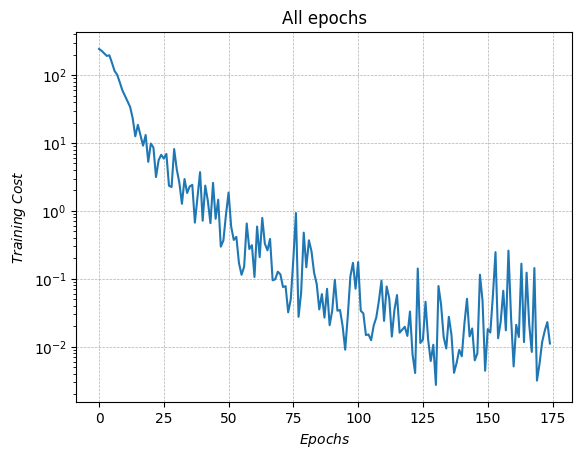

In [12]:
iteration = np.arange(len(epoch_info_dict.keys()))
plt.plot(iteration, epoch_info_dict.keys())

plt.title('All epochs')
plt.xlabel(r'$Epochs$')
plt.ylabel(r'$Training\;Cost$')
plt.yscale('log')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

## 10.2# - Extract the Best Model Weights

> During training, I stored both the loss and the model's weights for each epoch. This allows me to retrieve the weights that resulted in the lowest loss among those obtained during training. By keeping track of both the loss values and the corresponding model weights throughout the training process, I can later identify and utilize the model configuration that yielded the best performance, thereby ensuring optimal results.

In [13]:
min_loss_key = min(epoch_info_dict.keys())

best_model_state_dict = epoch_info_dict[min_loss_key]['model_state_dict']
best_epoch_number = epoch_info_dict[min_loss_key]['epoch_number']

print(f"Best model obtained at epoch {best_epoch_number} with loss: {min_loss_key:.4f}")

Best model obtained at epoch 130 with loss: 0.0027


## 10.3# - Apply Weights on Model

In [14]:
pre_trined_model = CNN()
pre_trined_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

## 10.4# - Pre-Trained Model Evaluation

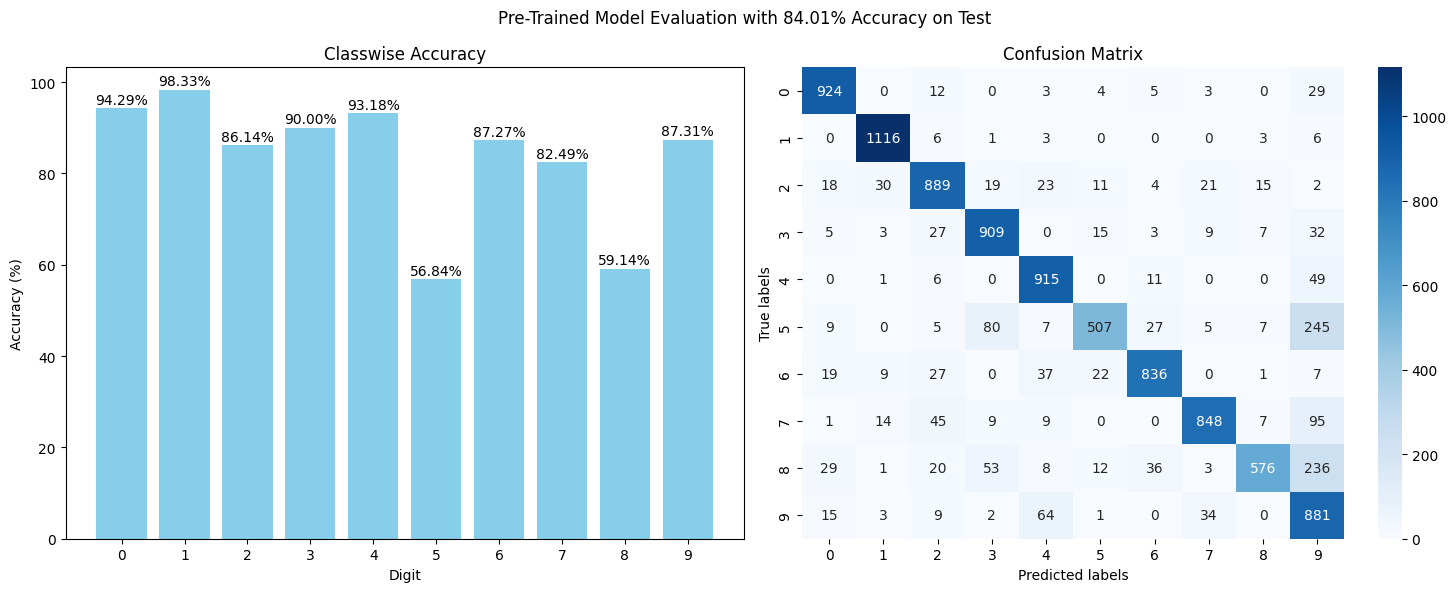

In [15]:
pre_trained_model_accuracy = eval_model(model=pre_trined_model)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

classwise_accuracy(model, ax=axs[0])
confusion_matrix_plot(model, ax=axs[1])

fig.suptitle(f'Pre-Trained Model Evaluation with {round(pre_trained_model_accuracy, 2)}% Accuracy on Test', fontsize=12)

plt.tight_layout()
plt.show()

## 10.5# Conclusion

> The graphs above indicate that certain images are less accurately predicted than others. It might be worthwhile to have more samples of those challenging images in our training dataset. This would allow our model to be trained on images where it struggles to predict the correct labels. By providing more training examples of these difficult cases, we can improve the model's performance on them and enhance its overall accuracy and robustness.

# 11# - Use Transformation to Augmente Train Dataset Size

## 11.1# - Define Transformations

> We use these transformations to enhance our training data for better model learning. The transformations involve random rotation (up to 20 degrees), slight translations (up to 10% of the image size), and scaling (between 80% and 120% of the original size). These variations mimic real-world scenarios and help our model generalize better. After applying these transformations, we convert the images into tensors for efficient processing. Overall, this helps our model become more robust and accurate when faced with diverse inputs during inference.

In [16]:
transformations = transforms.Compose([
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
])

## 11.2# - Apply Transformations

In [17]:
augmented_labeled_subset_dict = {}
for coef in range(1, 100, 10):
    augmented_labeled_subset = []
    for image, label in labeled_train_subset:
        augmented_images = [transformations(image) for _ in range(coef)] 
        augmented_labeled_subset.extend([(augmented_image, label) for augmented_image in augmented_images])
    augmented_labeled_subset_dict[coef] = augmented_labeled_subset

## 11.3# - Display New Generated Images from One

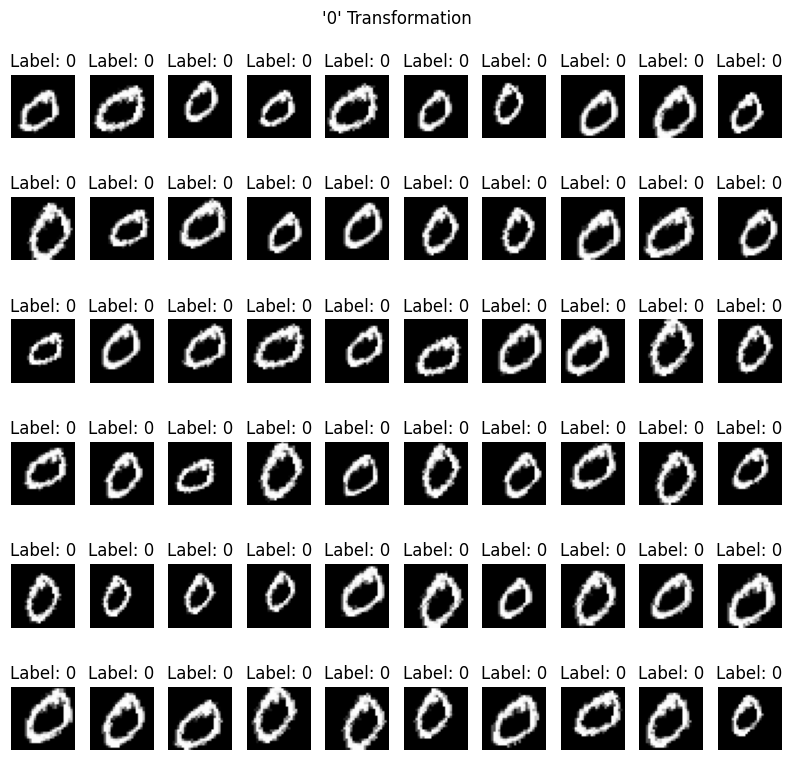

In [18]:
fig, axes = plt.subplots(6, 10, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = augmented_labeled_subset_dict[61][i]
    ax.imshow(image.squeeze().numpy(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

fig.suptitle("'0' Transformation", fontsize=12)

plt.tight_layout()
plt.show()

## 11.4# - Fine-Tune our Pre-Trained Model

> We're going to continue training our pre-trained model using the new dataset obtained through transformations. This dataset is created by augmenting our initial dataset of 100 images. We'll experiment with different levels of augmentation to observe how the number of images influences our loss. This will help us understand the impact of data augmentation on the training process and how it affects the model's performance.

In [19]:
# epoch_info_dict_on_augmented_dataset = {}

# for coef, augmented_labeled_subset in augmented_labeled_subset_dict.items():
#     augmented_trainloader = DataLoader(augmented_labeled_subset, batch_size=64, shuffle=True)
#     fine_tune_model = CNN()
#     fine_tune_model.load_state_dict(best_model_state_dict)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     fine_tune_model.to(device)

#     num_epochs = 20
#     epoch_info_dict = {}

#     print(f"Start training model...")
#     for epoch in range(num_epochs):
#         fine_tune_model.train() 
#         running_loss = 0.0
        
#         for inputs, labels in tqdm(augmented_trainloader):
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = fine_tune_model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
            
#         epoch_info_dict[running_loss] = {'model_state_dict': fine_tune_model.state_dict(), 'epoch_number': epoch}
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

#     epoch_info_dict_on_augmented_dataset[coef] = epoch_info_dict

#     print("Training done.")

## 11.5# - Display Loss Evolution

In [20]:
# for coef, epoch_info in epoch_info_dict_on_augmented_dataset.items():
#     loss = epoch_info.keys()
#     iteration = np.arange(len(loss))
#     plt.plot(iteration, loss, label=f'{coef*100}')

# plt.title('All epochs')
# plt.xlabel(r'$Epochs$')
# plt.ylabel(r'$Training\;Cost$')
# plt.yscale('log')
# plt.grid(linestyle = '--', linewidth = 0.5)
# plt.legend()
# plt.show()

![](./loss_evolution_coef.png)

## 11.6# - Conclusion 

> The analysis above indicates that my approach might not be the most effective. Increasing the amount of data via the defined transformations leads to a higher initial loss, which is expected. However, the concern is that this loss doesn't decrease significantly enough over time to justify training the model in this manner. Additionally, as we increase the data, it will require more time to train the model. Therefore, it seems necessary to reconsider the strategy for training the model, as the current approach may not yield satisfactory results within a reasonable timeframe.

# 12# - Generate Image in Each Epoch Using Transformation

## 12.1# - Define transformation

In [21]:
new_transformations = transforms.Compose([
    transforms.RandomAffine(degrees=40, translate=(0.3, 0.3), scale=(0.5, 1.5)),
    transforms.ToTensor(),
])

In [22]:
new_augmented_labeled_subset = []
for image, label in labeled_train_subset:
    new_augmented_images = [new_transformations(image) for _ in range(20)] 
    new_augmented_labeled_subset.extend([(augmented_image, label) for augmented_image in new_augmented_images])

new_augmented_trainloader = DataLoader(new_augmented_labeled_subset, batch_size=64, shuffle=True)

In [23]:
len(new_augmented_trainloader.dataset)

2000

## 12.2# - Fine-Tune our Pre-Trained Model Using Image Genaration by Transformations in each Epoch

In [24]:
# Define model with pre-trained weights
new_model = CNN()  
new_model.load_state_dict(best_model_state_dict)
new_model.to(device)  

# Define learning rate and criteration
learning_rate = 0.001
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
epoch_info_dict = {}

print(f"Start training model...")
for epoch in range(num_epochs):
    new_model.train() 

    # Define augmenter dataset to train the current epoch
    new_augmented_labeled_subset = []
    for image, label in labeled_train_subset:
        new_augmented_images = [new_transformations(image) for _ in range(20)] 
        new_augmented_labeled_subset.extend([(augmented_image, label) for augmented_image in new_augmented_images])

    new_augmented_trainloader = DataLoader(new_augmented_labeled_subset, batch_size=124, shuffle=True)

    running_loss = 0.0
    
    for inputs, labels in tqdm(new_augmented_trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_info_dict[running_loss] = {'model_state_dict': new_model.state_dict(), 'epoch_number': epoch}
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

print("Training done.")

Start training model...


100%|██████████| 17/17 [00:03<00:00,  5.47it/s]


Epoch 1/50, Loss: 6072.2136


100%|██████████| 17/17 [00:03<00:00,  4.92it/s]


Epoch 2/50, Loss: 4479.5135


100%|██████████| 17/17 [00:02<00:00,  6.65it/s]


Epoch 3/50, Loss: 4222.6774


100%|██████████| 17/17 [00:02<00:00,  6.78it/s]


Epoch 4/50, Loss: 4024.3150


100%|██████████| 17/17 [00:02<00:00,  5.89it/s]


Epoch 5/50, Loss: 3748.9714


100%|██████████| 17/17 [00:03<00:00,  5.53it/s]


Epoch 6/50, Loss: 3559.5321


100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Epoch 7/50, Loss: 3250.4426


100%|██████████| 17/17 [00:02<00:00,  5.69it/s]


Epoch 8/50, Loss: 3127.7032


100%|██████████| 17/17 [00:02<00:00,  5.90it/s]


Epoch 9/50, Loss: 3079.1834


100%|██████████| 17/17 [00:02<00:00,  6.24it/s]


Epoch 10/50, Loss: 2884.0027


100%|██████████| 17/17 [00:02<00:00,  6.85it/s]


Epoch 11/50, Loss: 2730.3178


100%|██████████| 17/17 [00:02<00:00,  6.87it/s]


Epoch 12/50, Loss: 2525.3426


100%|██████████| 17/17 [00:02<00:00,  6.91it/s]


Epoch 13/50, Loss: 2438.3104


100%|██████████| 17/17 [00:02<00:00,  7.03it/s]


Epoch 14/50, Loss: 2290.4498


100%|██████████| 17/17 [00:02<00:00,  6.99it/s]


Epoch 15/50, Loss: 2167.0773


100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


Epoch 16/50, Loss: 2162.3030


100%|██████████| 17/17 [00:02<00:00,  6.97it/s]


Epoch 17/50, Loss: 2026.5819


100%|██████████| 17/17 [00:02<00:00,  6.84it/s]


Epoch 18/50, Loss: 1909.2859


100%|██████████| 17/17 [00:02<00:00,  6.99it/s]


Epoch 19/50, Loss: 1815.2983


100%|██████████| 17/17 [00:02<00:00,  6.72it/s]


Epoch 20/50, Loss: 1847.6109


100%|██████████| 17/17 [00:02<00:00,  6.97it/s]


Epoch 21/50, Loss: 1626.0033


100%|██████████| 17/17 [00:02<00:00,  6.98it/s]


Epoch 22/50, Loss: 1603.5642


100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


Epoch 23/50, Loss: 1512.5636


100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


Epoch 24/50, Loss: 1494.8886


100%|██████████| 17/17 [00:02<00:00,  6.99it/s]


Epoch 25/50, Loss: 1603.0346


100%|██████████| 17/17 [00:02<00:00,  6.98it/s]


Epoch 26/50, Loss: 1468.9168


100%|██████████| 17/17 [00:02<00:00,  6.97it/s]


Epoch 27/50, Loss: 1436.3209


100%|██████████| 17/17 [00:02<00:00,  6.88it/s]


Epoch 28/50, Loss: 1373.0577


100%|██████████| 17/17 [00:02<00:00,  6.95it/s]


Epoch 29/50, Loss: 1328.9699


100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


Epoch 30/50, Loss: 1296.8699


100%|██████████| 17/17 [00:02<00:00,  6.89it/s]


Epoch 31/50, Loss: 1309.6917


100%|██████████| 17/17 [00:02<00:00,  6.79it/s]


Epoch 32/50, Loss: 1326.9008


100%|██████████| 17/17 [00:02<00:00,  6.91it/s]


Epoch 33/50, Loss: 1153.8056


100%|██████████| 17/17 [00:02<00:00,  6.94it/s]


Epoch 34/50, Loss: 1179.9987


100%|██████████| 17/17 [00:02<00:00,  6.92it/s]


Epoch 35/50, Loss: 1256.0716


100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


Epoch 36/50, Loss: 1110.4885


100%|██████████| 17/17 [00:02<00:00,  6.96it/s]


Epoch 37/50, Loss: 1148.3575


100%|██████████| 17/17 [00:02<00:00,  6.69it/s]


Epoch 38/50, Loss: 1068.0770


100%|██████████| 17/17 [00:02<00:00,  6.83it/s]


Epoch 39/50, Loss: 1086.1875


100%|██████████| 17/17 [00:02<00:00,  6.93it/s]


Epoch 40/50, Loss: 1062.0738


100%|██████████| 17/17 [00:02<00:00,  6.74it/s]


Epoch 41/50, Loss: 1079.1903


100%|██████████| 17/17 [00:02<00:00,  6.75it/s]


Epoch 42/50, Loss: 1076.8964


100%|██████████| 17/17 [00:02<00:00,  6.25it/s]


Epoch 43/50, Loss: 1023.6282


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 44/50, Loss: 1092.6733


100%|██████████| 17/17 [00:03<00:00,  5.33it/s]


Epoch 45/50, Loss: 982.2662


100%|██████████| 17/17 [00:02<00:00,  6.09it/s]


Epoch 46/50, Loss: 917.7644


100%|██████████| 17/17 [00:03<00:00,  5.20it/s]


Epoch 47/50, Loss: 916.3781


100%|██████████| 17/17 [00:02<00:00,  6.51it/s]


Epoch 48/50, Loss: 909.2722


100%|██████████| 17/17 [00:02<00:00,  6.66it/s]


Epoch 49/50, Loss: 821.4497


100%|██████████| 17/17 [00:02<00:00,  6.84it/s]

Epoch 50/50, Loss: 824.7559
Training done.


## 12.3# - Display Loss Evolution

In [ ]:
iteration = np.arange(len(epoch_info_dict.keys()))
plt.plot(iteration, epoch_info_dict.keys())

plt.title('All epochs')
plt.xlabel(r'$Epochs$')
plt.ylabel(r'$Training\;Cost$')
plt.yscale('log')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

## 12.4# - Extract the Best Model Weights

In [25]:
min_loss_key = min(epoch_info_dict.keys())

best_model_state_dict = epoch_info_dict[min_loss_key]['model_state_dict']
best_epoch_number = epoch_info_dict[min_loss_key]['epoch_number']

print(f"Best model obtained at epoch {best_epoch_number} with loss: {min_loss_key:.4f}")

Best model obtained at epoch 48 with loss: 821.4497


## 12.5# - Apply Weights on Model

In [26]:
pre_trined_model = CNN()
pre_trined_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

## 12.6# - Fine-Tuned Model Evaluation

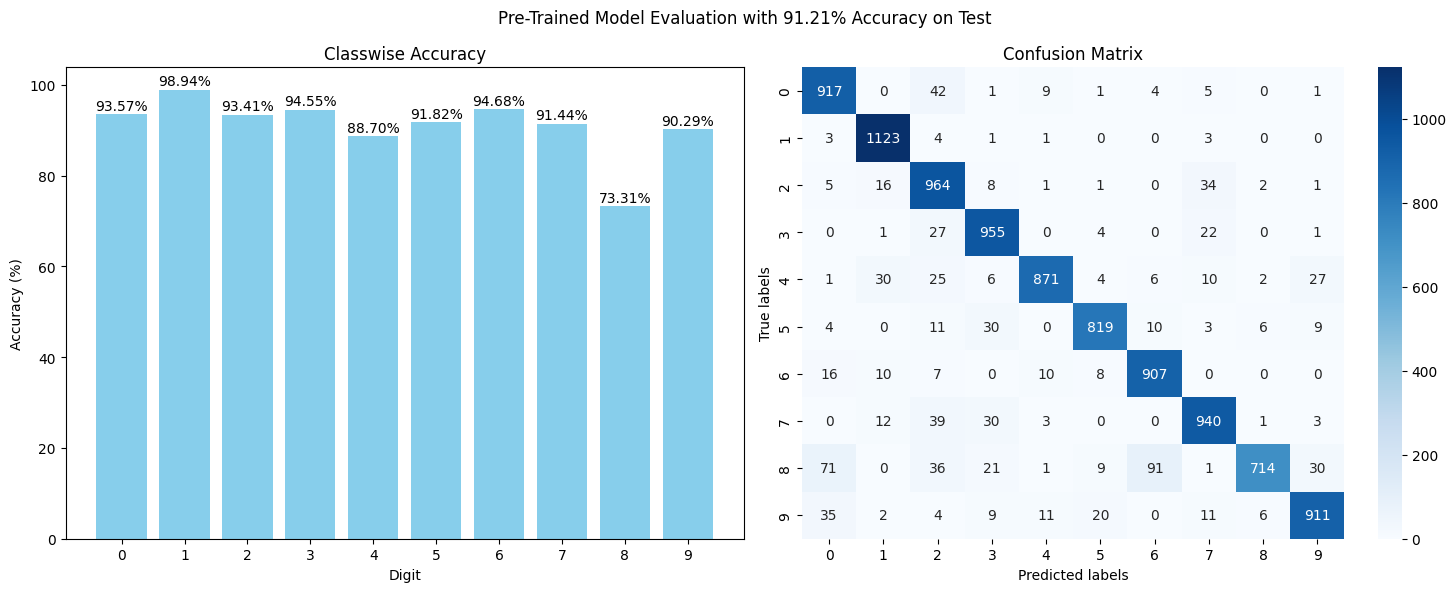

In [27]:
pre_trained_model_accuracy = eval_model(model=new_model)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

classwise_accuracy(new_model, ax=axs[0])
confusion_matrix_plot(new_model, ax=axs[1])

fig.suptitle(f'Pre-Trained Model Evaluation with {round(pre_trained_model_accuracy, 2)}% Accuracy on Test', fontsize=12)

plt.tight_layout()
plt.show()

# 13# - Use Unlabelized Images

> We're going to utilize the remainder of the MNIST train dataset without labels. We'll use the fine-tuned model to label these images and then utilize this new dataset to complete the training of our model. This approach allows us to make the most out of the available data and further improve the performance of our model.

## 13.1# - Define dataset without label

In [28]:
transform = transforms.Compose([
    transforms.ToTensor()
])

unlabeled_train_subset = [(transform(image)) for i, (image, label) in enumerate(trainset)]
unlabeled_train_loader = DataLoader(unlabeled_train_subset, batch_size=64, shuffle=True)

model.eval()

new_dataset = [] 
with torch.no_grad():
    for i, images in enumerate(unlabeled_train_loader):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        new_dataset.extend([(image, label.item()) for image, label in zip(images, predicted)])

## 13.2# - Display Labelized Images with Fine-Tuned Model

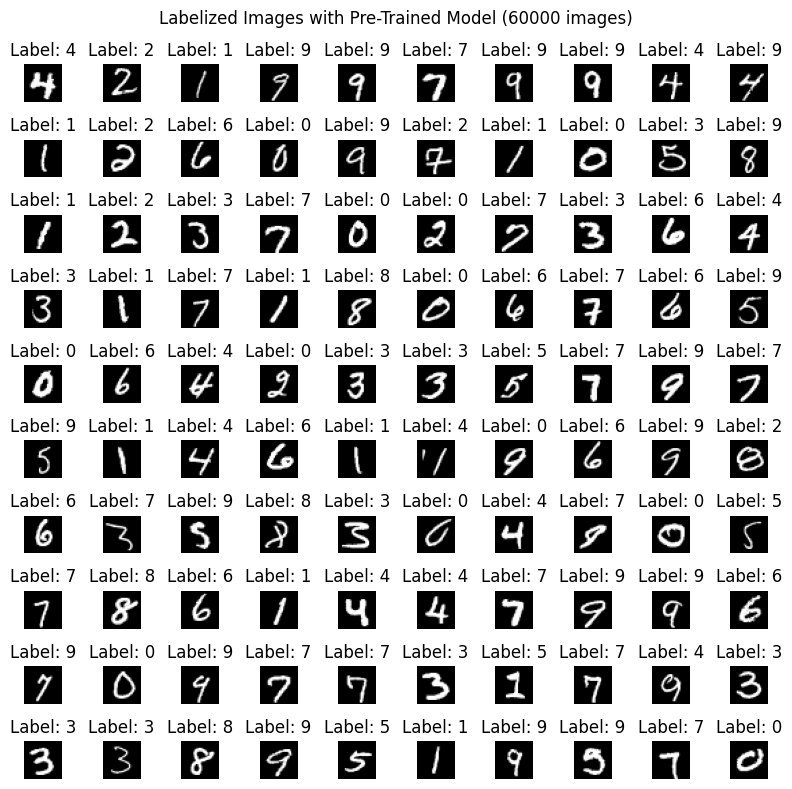

In [29]:
num_images_to_visualize = 100
fig, axes = plt.subplots(10, 10, figsize=(8, 8))

for i in range(num_images_to_visualize):
    image, pred_label = new_dataset[i]
    if image.shape[0] == 1:
        image = image.squeeze().numpy()
    else:
        image = image.permute(1, 2, 0).numpy()
    ax = axes[i // 10, i % 10]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {pred_label}')
    ax.axis('off')

fig.suptitle(f"Labelized Images with Pre-Trained Model ({len(new_dataset)} images)", fontsize=12)

plt.tight_layout()
plt.show()

### Comment 
> We can observe that some images have been mislabeled by our fine-tuned model. This is expected since our model doesn't have 100% accuracy. Therefore, we'll introduce uncertainty in continuing the training of our model. It's crucial to ensure that this uncertainty isn't too significant and doesn't deteriorate our model rather than improving it.

## 13.3# - Define new DataLoader Using 10 000 Images from the New Dataset

In [35]:
converted_new_dataset = [(image, label) for image, label in new_dataset]

new_loader = DataLoader(converted_new_dataset[:5000], batch_size=512, shuffle=True)

## 13.4# - Train our Model with this New Dataset

In [45]:
# Define model with pre-trained weights
new_model = CNN()  
new_model.load_state_dict(best_model_state_dict)
new_model.to(device)  

# Define learning rate and criteration
learning_rate = 0.001
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 100
epoch_info_dict = {}

print(f"Start training model...")
for epoch in range(num_epochs):
    new_model.train() 
    running_loss = 0.0
    
    for inputs, labels in tqdm(new_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_info_dict[running_loss] = {'model_state_dict': new_model.state_dict(), 'epoch_number': epoch}
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss:.4f}")

print("Training done.")

Start training model...


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch 1/100, Loss: 4424.5949


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 2/100, Loss: 2960.3167


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 3/100, Loss: 2418.1828


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch 4/100, Loss: 2229.6313


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch 5/100, Loss: 1981.5282


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 6/100, Loss: 1769.0074


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 7/100, Loss: 1672.9925


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 8/100, Loss: 1499.3782


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch 9/100, Loss: 1452.2444


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 10/100, Loss: 1375.7147


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch 11/100, Loss: 1323.2859


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 12/100, Loss: 1169.0878


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 13/100, Loss: 1177.9009


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch 14/100, Loss: 1117.7944


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Epoch 15/100, Loss: 1104.2301


100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


Epoch 16/100, Loss: 1037.6973


100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch 17/100, Loss: 944.5868


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 18/100, Loss: 974.7550


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 19/100, Loss: 955.0432


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Epoch 20/100, Loss: 849.6243


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch 21/100, Loss: 805.6413


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Epoch 22/100, Loss: 783.7042


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Epoch 23/100, Loss: 804.8071


100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Epoch 24/100, Loss: 792.3301


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Epoch 25/100, Loss: 701.8733


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch 26/100, Loss: 738.2915


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch 27/100, Loss: 769.9565


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch 28/100, Loss: 726.9188


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch 29/100, Loss: 699.4422


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch 30/100, Loss: 728.0393


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 31/100, Loss: 632.8842


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Epoch 32/100, Loss: 654.8717


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Epoch 33/100, Loss: 660.6850


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch 34/100, Loss: 607.0447


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch 35/100, Loss: 572.4338


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 36/100, Loss: 566.2794


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 37/100, Loss: 589.8281


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 38/100, Loss: 552.4149


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 39/100, Loss: 575.2261


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 40/100, Loss: 589.5822


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 41/100, Loss: 603.7329


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 42/100, Loss: 506.6606


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch 43/100, Loss: 518.3066


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 44/100, Loss: 501.4542


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 45/100, Loss: 533.1097


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch 46/100, Loss: 510.2919


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch 47/100, Loss: 505.6174


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch 48/100, Loss: 464.4691


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 49/100, Loss: 447.5710


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 50/100, Loss: 428.8532


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 51/100, Loss: 444.4546


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 52/100, Loss: 467.7278


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 53/100, Loss: 461.8327


100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 54/100, Loss: 441.4553


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 55/100, Loss: 455.4012


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 56/100, Loss: 417.6316


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 57/100, Loss: 391.6326


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 58/100, Loss: 359.7742


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 59/100, Loss: 400.1888


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 60/100, Loss: 308.8044


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 61/100, Loss: 414.0806


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 62/100, Loss: 385.2259


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 63/100, Loss: 412.2423


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 64/100, Loss: 354.2103


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 65/100, Loss: 356.7545


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 66/100, Loss: 348.9320


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 67/100, Loss: 308.4087


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 68/100, Loss: 277.1090


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 69/100, Loss: 321.7882


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 70/100, Loss: 333.5427


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 71/100, Loss: 436.3887


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 72/100, Loss: 365.0019


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Epoch 73/100, Loss: 283.6231


100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


Epoch 74/100, Loss: 343.5174


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 75/100, Loss: 330.7862


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 76/100, Loss: 297.5902


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 77/100, Loss: 307.1432


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 78/100, Loss: 334.5616


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 79/100, Loss: 286.5096


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 80/100, Loss: 355.6989


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 81/100, Loss: 330.3236


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 82/100, Loss: 298.2316


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 83/100, Loss: 293.2253


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 84/100, Loss: 301.2341


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 85/100, Loss: 259.9771


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 86/100, Loss: 303.5139


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 87/100, Loss: 298.2314


100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 88/100, Loss: 278.4424


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 89/100, Loss: 276.5918


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch 90/100, Loss: 271.4946


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 91/100, Loss: 218.5745


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 92/100, Loss: 284.3188


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 93/100, Loss: 312.9039


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 94/100, Loss: 285.7704


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 95/100, Loss: 288.6230


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 96/100, Loss: 261.2350


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 97/100, Loss: 235.7901


100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 98/100, Loss: 243.7190


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 99/100, Loss: 232.3745


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

Epoch 100/100, Loss: 221.7098
Training done.


## 13.5# - Display Loss Evolution

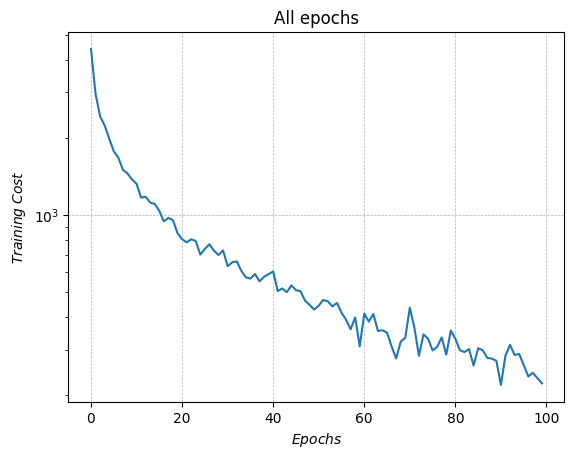

In [46]:
iteration = np.arange(len(epoch_info_dict.keys()))
plt.plot(iteration, epoch_info_dict.keys())

plt.title('All epochs')
plt.xlabel(r'$Epochs$')
plt.ylabel(r'$Training\;Cost$')
plt.yscale('log')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

## 13.6# - Extract the Best Model Weights

In [52]:
new_min_loss_key = min(epoch_info_dict.keys())

new_best_model_state_dict = epoch_info_dict[new_min_loss_key]['model_state_dict']
new_best_epoch_number = epoch_info_dict[new_min_loss_key]['epoch_number']

print(f"Best model obtained at epoch {new_best_epoch_number} with loss: {new_min_loss_key:.4f}")

Best model obtained at epoch 90 with loss: 218.5745


## 13.7# - Apply Weights on Model

In [53]:
trained_model = CNN()
trained_model.load_state_dict(new_best_model_state_dict)

<All keys matched successfully>

## 13.8# - Trained Model Evaluation

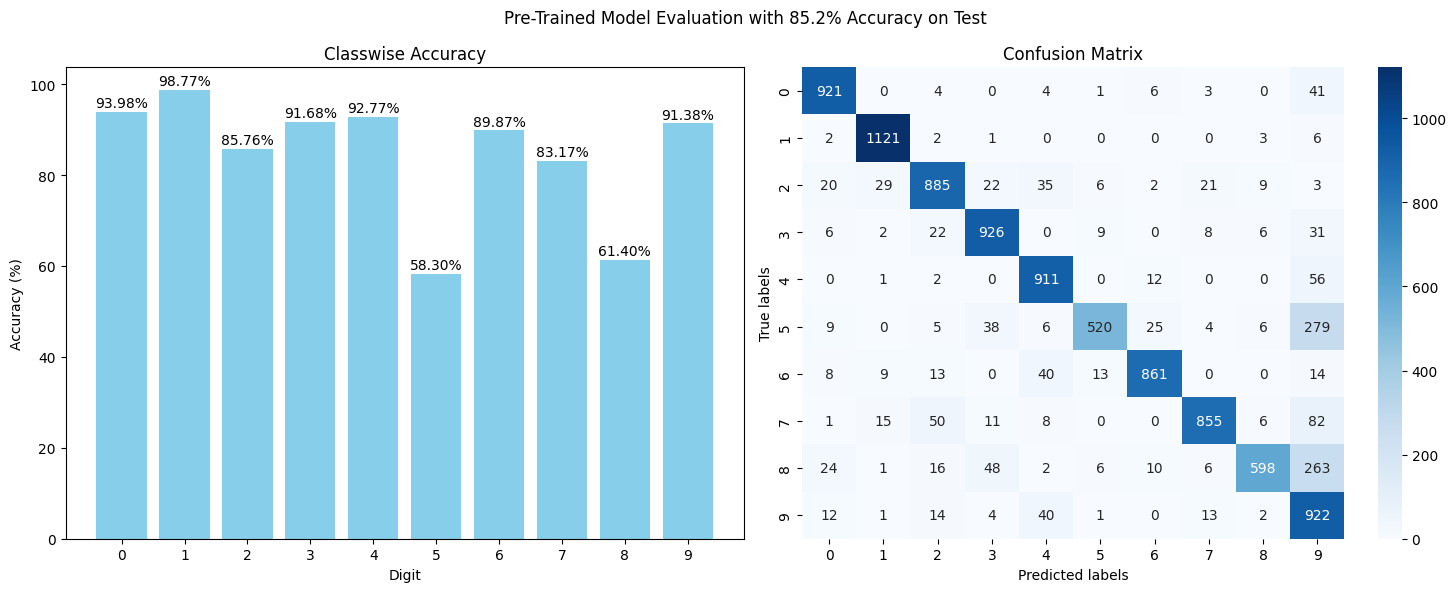

In [54]:
pre_trained_model_accuracy = eval_model(model=trained_model)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

classwise_accuracy(trained_model, ax=axs[0])
confusion_matrix_plot(trained_model, ax=axs[1])

fig.suptitle(f'Pre-Trained Model Evaluation with {round(pre_trained_model_accuracy, 2)}% Accuracy on Test', fontsize=12)

plt.tight_layout()
plt.show()